In [1]:
# prototype

In [2]:
import os
from os.path import join
import random
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage import measure
from torch.utils.data import Dataset, DataLoader
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet

from monai.networks.nets import UNet

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from pathlib import Path
from datetime import datetime

seed = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

In [3]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

__Python VERSION: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
__pyTorch VERSION: 2.8.0.dev20250416+cu128
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:42:46_Pacific_Standard_Time_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0
__CUDNN VERSION: 90701
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [4]:
from utils.loading_utils import *
from utils.logging import *
from visualization.visualization import *
#from ml.dataset_ import BrainMetDatasetPreloaded, GridSamplerWrapper
from ml.dataset_ import BrainMetPytorchDataset
from ml.trainer import Trainer, load_trained_model

In [5]:
%load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir runs

Launching TensorBoard...

In [6]:
from tensorboard import notebook
notebook.list()
#notebook.display(port=6006, height=1000)

#http://127.0.0.1:6006/?darkMode=true

Known TensorBoard instances:
  - port 6006: logdir runs (started 0:00:00 ago; pid 27000)


In [7]:
TRAIN_ROOT_DIR  = './MICCAI-LH-BraTS2025-MET-Challenge-Training/'
HELPER_ROOT_DIR = './training_helper/'

dataset = BrainMetPytorchDataset(HELPER_ROOT_DIR, patch_size=(128, 128, 96))
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True, pin_memory=True)
validation_dataset = DataLoader(validation_dataset, batch_size=16, num_workers=4, shuffle=False, pin_memory=True)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=5,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


def dice_loss(probs, targets, epsilon=1e-5):
    # Assumes probs: [B, C, H, W, D], targets: [B, C, H, W, D]
    intersection = (probs * targets).sum(dim=(2, 3, 4))
    union = probs.sum(dim=(2, 3, 4)) + targets.sum(dim=(2, 3, 4))
    dice = 2. * intersection / (union + epsilon)
    return 1 - dice.mean()

ce_loss = nn.CrossEntropyLoss()

def loss_fn(logits, target):
    target = target.to(torch.long)
    if target.ndim == 5 and target.shape[1] == 1:
        target = target[:, 0]              # [B, H, W, D]
    ce = torch.nn.functional.cross_entropy(logits, target)

    # --- Dice loss ---
    probs = torch.softmax(logits, dim=1)  # [B, C, H, W, D]
    one_hot_target = torch.nn.functional.one_hot(target, num_classes=logits.shape[1])  # [B, H, W, D, C]
    one_hot_target = one_hot_target.permute(0, 4, 1, 2, 3).float()    # [B, C, H, W, D]

    dice = dice_loss(probs, one_hot_target)

    return ce + dice

def dice_score(preds, targets, epsilon=1e-5):
    """
    Computes mean Dice score over all classes, including background.

    Args:
        preds: [B, H, W, D] — predicted class labels
        targets: [B, H, W, D] — ground truth labels
    """
    num_classes = int(torch.max(targets).item()) + 1
    dice_scores = []

    for c in range(num_classes):  # include background (class 0)
        pred_c = (preds == c).float()
        target_c = (targets == c).float()

        intersection = (pred_c * target_c).sum(dim=(1, 2, 3))
        union = pred_c.sum(dim=(1, 2, 3)) + target_c.sum(dim=(1, 2, 3))

        dice = (2 * intersection + epsilon) / (union + epsilon)
        dice_scores.append(dice)

    return torch.stack(dice_scores).mean()



optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Epoch: 1 [train]:   0%|          | 0/1 [00:00<?, ?it/s]D:\Schule\JKU\MA_2_Semester\MedicalImaging\ml\trainer.py:116: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  losses.append(loss_value.item())
Epoch: 1 [valid]: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it, valid_loss=2.8704]



Epoch Summary:
  train-loss: 2.9098
  metric-loss: 0.0048
  valid-loss: 2.8704


Epoch: 2 [valid]: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it, valid_loss=2.8340]



Epoch Summary:
  train-loss: 2.8572
  metric-loss: 0.0048
  valid-loss: 2.8340


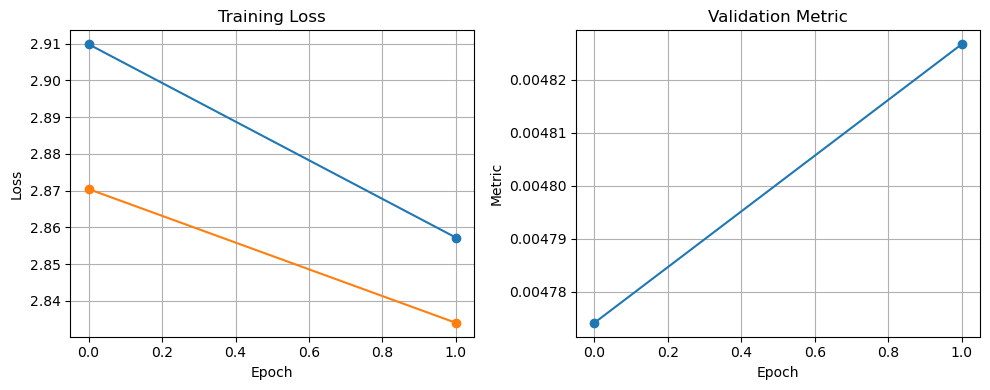

In [9]:
#train_dataloader, val_dataloader = load_data(batch_size=args.batch_size, num_workers=args.num_workers, use_torchio_version=args.use_torchio)
num_epochs = 10
dir = f'./runs/run_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
progress = ProgressBar()
tb = TensorBoard(path=dir)
checkpoints = Backup(path=dir, every=5)

trainer = Trainer(model, optimizer, loss_fn, dice_score, device=device, use_torchio=False)
checkpoints.attach_trainer(trainer)
trainer.tracker.loggers = [progress, tb, checkpoints]

trainer.train(train_loader=train_dataloader, val_loader=validation_dataset, epochs=2)

In [11]:
loaded_model = load_trained_model(
    run_dir="./runs/run_2025-05-12_19-11-47",
    model_class=UNet,
    device='cuda',
    spatial_dims=3,
    in_channels=4,
    out_channels=5,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2
)

Loading checkpoint: epoch_005.pth


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def resample_nearest_numpy(volume, input_spacing, target_spacing=(1.0, 1.0, 1.0)):
    input_spacing = np.array(input_spacing)
    target_spacing = np.array(target_spacing)
    zoom_factors = input_spacing / target_spacing

    input_shape = np.array(volume.shape)
    output_shape = np.round(input_shape * zoom_factors).astype(int)

    # Create output grid
    dz = np.linspace(0, input_shape[0] - 1, output_shape[0]).astype(int)
    dy = np.linspace(0, input_shape[1] - 1, output_shape[1]).astype(int)
    dx = np.linspace(0, input_shape[2] - 1, output_shape[2]).astype(int)

    # Meshgrid for indexing
    zz, yy, xx = np.meshgrid(dz, dy, dx, indexing='ij')

    return volume[zz, yy, xx]

# Example usage:

tmp= 'BraTS-MET-00758-000'
path = f"./MICCAI-LH-BraTS2025-MET-Challenge-Training/{tmp}/{tmp}-t1c.nii.gz"

img = nib.load(path)
data = img.get_fdata(dtype=np.float32)
spacing = img.header.get_zooms()[:3]

#print(data.shape)
#print(spacing)

# Resample to (1.0, 1.0, 1.0)
resampled  = resample_nearest_numpy(data, spacing, target_spacing=(1.0, 1.0, 1.0))

print("Original shape:", data.shape)
print("Original spacing:", spacing)
print("Original spacing:", type(spacing))
print("Resampled shape:", resampled.shape)
print("Resampled shape:", type(resampled))

# === Visualize center slice ===
z_orig = data.shape[2] // 2
z_resampled = resampled.shape[2] // 2

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data[:, :, z_orig].T, cmap="gray", origin="lower")
plt.title(f"Original\nShape: {data.shape}\nSpacing: {spacing}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(resampled[:, :, z_resampled].T, cmap="gray", origin="lower")
plt.title(f"Resampled\nShape: {resampled.shape}\nSpacing: (1.0, 1.0, 1.0)")
plt.axis("off")

plt.tight_layout()
plt.show()